In [14]:
from config import DATA_PATH
from preloading import load_datasets

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

import torch
import torchtext
import nltk
from torchtext.data import get_tokenizer
from tqdm import tqdm
tqdm.pandas()
from nltk.corpus import stopwords
from torchtext.vocab import GloVe

In [15]:
tokenizer = get_tokenizer("basic_english")
stop = stopwords.words('english')

In [16]:
def strip_text(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    text = re.sub(r'https?:/\/\S+', ' ', text)
    return text.strip()

In [17]:
def review_clean_list(text):
    word_list = tokenizer(text)
    strip_words = [strip_text(word) for word in word_list]
    str_list = list(filter(None, strip_words))
    return str_list



In [18]:
dim=300
global_vectors = GloVe(name='840B', dim=dim)

In [19]:
# max_words = 512
embed_len = dim

def vectorize_batch(batch):
    X, Y = list(zip(*batch))
    # X = [tokenizer(x) for x in X]
    # X = [tokens+[""] * (max_words-len(tokens))  if len(tokens)<max_words else tokens[:max_words] for tokens in X]
    X_tensor_128_300 = torch.zeros(len(batch), embed_len)
    for i, tokens in enumerate(X):
        token_x_300 = global_vectors.get_vecs_by_tokens(tokens)
        # print(f'token_x_???_300 shape: {token_x_300.shape}')
        token_300 = token_x_300.mean(dim=0)
        # print(f'token_300 shape: {token_300.shape}')
        X_tensor_128_300[i] = token_300
    Y_tensor = torch.tensor(Y)
    # return X_tensor.reshape(len(batch), -1), Y_tensor.reshape(len(batch), -1)
    # return X_tensor.reshape(len(batch), -1), Y_tensor
    return X_tensor_128_300.reshape(len(batch), -1), Y_tensor

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd


In [111]:
def calc_mean_token(wordlist):
    token_x_300 = global_vectors.get_vecs_by_tokens(wordlist)
    return token_x_300.mean(dim=0)



class ClassificationDataset(Dataset):

    def __init__(self, file_path):

        print(f'processing of {file_path} started ...')
        # Read data
        self.data_df = pd.read_csv(file_path)

        print("tokenizing ...")
        self.data_df['tokens'] =  self.data_df.progress_apply(lambda x: tokenizer(x["review"]), axis=1)

        print("calculating mean tokens ...")
        self.data_df['mean_token'] =  self.data_df.progress_apply(lambda x: calc_mean_token(x["tokens"]), axis=1)

        # pat = r'\b(?:{})\b'.format('|'.join(stop))
        # # remove stop stop words
        # print('removing stopwords ...')
        # self.data_df['clean_review'] = self.data_df['review'].str.lower().replace(pat, '', regex=True)
        # self.data_df['clean_review'] = self.data_df['clean_review'].str.replace(r'\s+', ' ', regex=True)
        #
        # print('cleaning words ...')
        # self.data_df['clean_review'] =  self.data_df.progress_apply(lambda x: review_clean_list(x['clean_review']), axis=1)
        #
        # print('calculating mean clean tokens ...')
        # self.data_df['mean_token'] =  self.data_df.progress_apply(lambda x: calc_mean_token(x['clean_review']), axis=1)

        print('converting sentiment to number ...')
        self.data_df['target'] = pd.factorize(self.data_df['sentiment'], sort=True)[0]

        print(f'processing of {file_path} finished !')

    def __getitem__(self, item):
        return {'mean_token': self.data_df.iloc[item]['mean_token'], 'target': self.data_df.iloc[item]['target']}

    def __len__(self):
        return len(self.data_df)

In [112]:
train_dataset = ClassificationDataset(f'{DATA_PATH}/IMDB_train.csv', )
test_dataset = ClassificationDataset(f'{DATA_PATH}/IMDB_test.csv', )

processing of ./data/IMDB_train.csv started ...
tokenizing ...


100%|██████████| 40000/40000 [00:04<00:00, 9526.97it/s] 


calculating mean tokens ...


100%|██████████| 40000/40000 [00:27<00:00, 1471.49it/s]


converting sentiment to number ...
processing of ./data/IMDB_train.csv finished !
processing of ./data/IMDB_test.csv started ...
tokenizing ...


100%|██████████| 10000/10000 [00:01<00:00, 9914.79it/s]


calculating mean tokens ...


100%|██████████| 10000/10000 [00:05<00:00, 1692.71it/s]

converting sentiment to number ...
processing of ./data/IMDB_test.csv finished !


In [113]:
next(iter(train_dataset))

{'mean_token': tensor([-7.9182e-02,  1.6575e-01, -7.4260e-02, -9.8066e-02,  4.1668e-02,
          6.3572e-02,  1.4033e-02, -1.2692e-01, -4.5773e-02,  2.1155e+00,
         -1.4825e-01,  8.8027e-02,  8.2067e-02, -5.3264e-02, -1.3754e-01,
         -9.5012e-02, -4.2865e-02,  9.5066e-01, -1.9094e-01, -2.4616e-02,
         -1.3271e-03, -3.8259e-02,  7.3301e-03, -3.1398e-02, -2.3603e-02,
          5.2116e-02, -6.6549e-02, -8.2620e-02,  7.0907e-02, -7.0348e-02,
         -3.0290e-02,  2.0863e-02, -7.9536e-02,  8.0419e-02,  9.9465e-03,
         -7.1210e-02,  3.5911e-03,  8.3683e-02, -5.1194e-02,  2.3098e-02,
         -1.6146e-02,  3.9066e-02,  4.0759e-02,  1.8458e-03, -9.8923e-03,
          4.8018e-02, -1.2642e-01,  1.5840e-02,  4.3178e-02, -1.5053e-03,
         -7.4081e-02, -2.7364e-02, -5.6831e-03, -3.4428e-02,  7.8554e-02,
          2.7589e-02, -7.5855e-03, -1.7494e-01,  3.7293e-02, -4.9840e-02,
         -6.6120e-03, -5.9214e-02, -5.8622e-02,  2.1997e-01,  6.6509e-02,
         -5.5419e-02,  5

In [114]:
batch_size=128

In [115]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)# , collate_fn=vectorize_batch)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #, collate_fn=vectorize_batch)

In [118]:
loader_item_dict = next(iter(train_loader))
loader_item_dict

{'mean_token': tensor([[ 0.0432,  0.1114, -0.0638,  ..., -0.0274, -0.0961,  0.0633],
         [-0.0652,  0.1416, -0.1324,  ..., -0.0518, -0.0560,  0.1001],
         [-0.0760,  0.2051, -0.1376,  ..., -0.0029, -0.0295,  0.0411],
         ...,
         [-0.1023,  0.1504, -0.1147,  ..., -0.0733,  0.0057,  0.0415],
         [-0.0542,  0.0986, -0.0880,  ..., -0.0239, -0.0298,  0.0352],
         [ 0.0082,  0.1100, -0.0696,  ..., -0.0583, -0.0206,  0.0395]]),
 'target': tensor([1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
         1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
         0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
         1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
         1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
         1, 0, 0, 1, 1, 0, 0, 1])}

In [119]:
loader_item_dict['mean_token'].shape

torch.Size([128, 300])

In [133]:
from torch import nn
from torch.nn import functional as F

class EmbeddingClassifier(nn.Module):
    def __init__(self, ):
        super(EmbeddingClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(300, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 2),
            # nn.Dropout(0.2)
        )

    def forward(self, X_batch):
        hidden_128_1 =  self.seq(X_batch)
        return hidden_128_1

In [126]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU


    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, loader_item_dict in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        X = loader_item_dict['mean_token'].to(DEVICE)
        Y = loader_item_dict['target'].to(DEVICE)

        #-- Forward:
        if bTrain == True:
            
            #-- Store computational graph:
            mOut = oModel(X)

            loss = Loss  (mOut,      Y)

        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mOut = oModel(X)
                loss = Loss  (mOut,      Y)

        #-- Backward:
        if bTrain == True:

            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        with torch.no_grad():

            Nb           = X.shape[0]
            count       += Nb
            epochLoss   += Nb * loss.item()
            epochMetric += Nb * Metric(mOut, Y)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [127]:
nEpochs    = 20
nIter      = nEpochs * len(train_loader)
import torch.optim as optim
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import Accuracy

Loss   = nn.CrossEntropyLoss()
Metric = Accuracy           ()

DEVICE = torch.device       ("cuda:0" if torch.cuda.is_available() else "cpu") 

oModel     = EmbeddingClassifier  ().to(DEVICE, )
oOptim     = optim.AdamW(oModel.parameters(), lr=0.001, betas=(0.9, 0.99), weight_decay=1e-2)
oScheduler = OneCycleLR (oOptim, max_lr=0.001, total_steps=nIter)
lHistory   = TrainModel (oModel, train_loader, test_loader, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=Epoch, sModelName='EmbeddingCLS')

AttributeError: 'OneCycleLR' object has no attribute 'zero_grad'

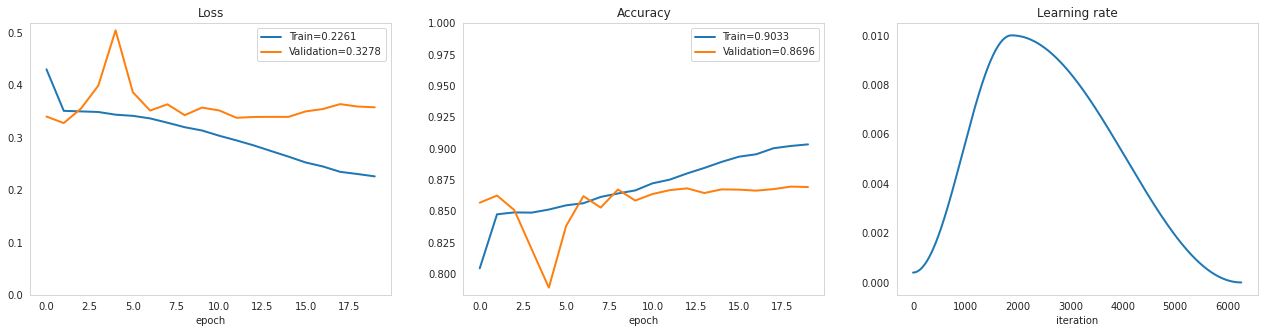

In [75]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

In [30]:
x = torch.tensor([1, 2, 3 ,4 , 5], dtype=float)

In [31]:
x.mean()

tensor(3., dtype=torch.float64)

In [82]:
train_dataset[0]

(tensor([-7.9182e-02,  1.6575e-01, -7.4260e-02, -9.8066e-02,  4.1668e-02,
          6.3572e-02,  1.4033e-02, -1.2692e-01, -4.5773e-02,  2.1155e+00,
         -1.4825e-01,  8.8027e-02,  8.2067e-02, -5.3264e-02, -1.3754e-01,
         -9.5012e-02, -4.2865e-02,  9.5066e-01, -1.9094e-01, -2.4616e-02,
         -1.3271e-03, -3.8259e-02,  7.3301e-03, -3.1398e-02, -2.3603e-02,
          5.2116e-02, -6.6549e-02, -8.2620e-02,  7.0907e-02, -7.0348e-02,
         -3.0290e-02,  2.0863e-02, -7.9536e-02,  8.0419e-02,  9.9465e-03,
         -7.1210e-02,  3.5911e-03,  8.3683e-02, -5.1194e-02,  2.3098e-02,
         -1.6146e-02,  3.9066e-02,  4.0759e-02,  1.8458e-03, -9.8923e-03,
          4.8018e-02, -1.2642e-01,  1.5840e-02,  4.3178e-02, -1.5053e-03,
         -7.4081e-02, -2.7364e-02, -5.6831e-03, -3.4428e-02,  7.8554e-02,
          2.7589e-02, -7.5855e-03, -1.7494e-01,  3.7293e-02, -4.9840e-02,
         -6.6120e-03, -5.9214e-02, -5.8622e-02,  2.1997e-01,  6.6509e-02,
         -5.5419e-02,  5.5472e-03,  3.

In [81]:
train_dataset.data_df['mean_dirty_token'][0]

tensor([-7.9182e-02,  1.6575e-01, -7.4260e-02, -9.8066e-02,  4.1668e-02,
         6.3572e-02,  1.4033e-02, -1.2692e-01, -4.5773e-02,  2.1155e+00,
        -1.4825e-01,  8.8027e-02,  8.2067e-02, -5.3264e-02, -1.3754e-01,
        -9.5012e-02, -4.2865e-02,  9.5066e-01, -1.9094e-01, -2.4616e-02,
        -1.3271e-03, -3.8259e-02,  7.3301e-03, -3.1398e-02, -2.3603e-02,
         5.2116e-02, -6.6549e-02, -8.2620e-02,  7.0907e-02, -7.0348e-02,
        -3.0290e-02,  2.0863e-02, -7.9536e-02,  8.0419e-02,  9.9465e-03,
        -7.1210e-02,  3.5911e-03,  8.3683e-02, -5.1194e-02,  2.3098e-02,
        -1.6146e-02,  3.9066e-02,  4.0759e-02,  1.8458e-03, -9.8923e-03,
         4.8018e-02, -1.2642e-01,  1.5840e-02,  4.3178e-02, -1.5053e-03,
        -7.4081e-02, -2.7364e-02, -5.6831e-03, -3.4428e-02,  7.8554e-02,
         2.7589e-02, -7.5855e-03, -1.7494e-01,  3.7293e-02, -4.9840e-02,
        -6.6120e-03, -5.9214e-02, -5.8622e-02,  2.1997e-01,  6.6509e-02,
        -5.5419e-02,  5.5472e-03,  3.5946e-02,  3.1

In [128]:
model

NameError: name 'model' is not defined

In [129]:
oModel

EmbeddingClassifier(
  (seq): Sequential(
    (0): Linear(in_features=300, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [130]:
from torchviz import make_dot

In [132]:
yhat = oModel(next(iter(train_loader)))

TypeError: linear(): argument 'input' (position 1) must be Tensor, not dict

In [134]:
loader_item_dict = next(iter(train_loader))

In [135]:
loader_item_dict

{'mean_token': tensor([[-0.0374,  0.1976, -0.1323,  ..., -0.0661, -0.0478,  0.0235],
         [ 0.0609,  0.1522, -0.1360,  ..., -0.0178, -0.0225,  0.1384],
         [-0.0032,  0.1393, -0.1071,  ..., -0.0286, -0.0874,  0.0259],
         ...,
         [-0.0181,  0.1446, -0.0800,  ..., -0.0969, -0.0799,  0.0235],
         [-0.0181,  0.0868, -0.1531,  ..., -0.0003, -0.0435,  0.0910],
         [-0.0362,  0.2014, -0.1444,  ..., -0.0219, -0.0357,  0.0861]]),
 'target': tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
         1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
         1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
         1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
         0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
         0, 0, 0, 0, 0, 1, 0, 0])}

In [136]:
Y = oModel(loader_item_dict['mean_token'])

In [138]:
make_dot(Y, params=dict(list(oModel.named_parameters()))).render("rnn_torchviz", format="png")

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH